<a href="https://colab.research.google.com/github/RobDrie/IT-Tools-Spark/blob/main/Spark_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=43dfbe12946023b6b157867813ed297316dc63d3f0368fa1fe2915a96f8dae8b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import desc, dayofweek, col, datediff, lit, when

In [19]:
spark = SparkSession.builder \
    .appName("YourApp") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

## Load & Process gas price data with Spark
# * Download 2019 to 2023 gas price data
* Download gas Stations file & Services file (2022 versions)

In [3]:
!git clone https://github.com/rvm-courses/GasPrices

fatal: destination path 'GasPrices' already exists and is not an empty directory.


## Data Preparation - step 1
* Read and merge all gas files
* Split date in year, month, week of the year
* Prepare latitude & longitude for mapping (divide by the right power of 10)
* Make data available as a table in order to be able to use Spark S

In [3]:
def price_download(year_list):
  prices_df = None

  for year in year_list:
    file_path = f'GasPrices/Prix{year}.csv.gz'
    current_df = spark.read.option("header", "False").option('delimiter', ';').csv(file_path)

    if prices_df is None:
      prices_df = current_df
    else:
      prices_df = prices_df.union(current_df)

  return prices_df

In [30]:
# Download price data for 2019 to 2023
year_list = ['2019', '2020', '2021', '2022S1', '2022S2']
prices_df = price_download(year_list)

file_path = 'GasPrices/Stations2022.csv.gz'
stations_df = spark.read.option("header", "False").option('delimiter', '|').csv(file_path)

file_path = 'GasPrices/Services2022.csv.gz'
services_df = spark.read.option("header", "False").option('delimiter', '|').csv(file_path)

### Variable definitions
* id_pdv = points of sales
* cp = zip code
* pop = type of population
* latitude
* longitude
* date
* id carburant = gas id
* nom carburant = gas label
* prix = price in millieuros

In [31]:
def rename_columns(df, new_column_names):
    for old_name, new_name in zip(df.columns, new_column_names):
        df = df.withColumnRenamed(old_name, new_name)
    return df

# Rename columns for each DataFrame
prices_df = rename_columns(prices_df, ['id_pdv', 'cp', 'pop', 'latitude', 'longitude', 'date', 'id_carburant', 'nom_carburant', 'prix'])
stations_df = rename_columns(stations_df, ['id_pdv', 'cp', 'pop', 'latitude', 'longitude', 'adresse', 'ville'])
services_df = rename_columns(services_df, ['id_pdv', 'cp', 'pop', 'latitude', 'longitude', 'services'])

prices_df.show(5)

+-------+-----+---+--------+---------+-------------------+------------+-------------+----+
| id_pdv|   cp|pop|latitude|longitude|               date|id_carburant|nom_carburant|prix|
+-------+-----+---+--------+---------+-------------------+------------+-------------+----+
|1000001|01000|  R| 4620114|   519791|2019-01-04T10:53:48|           1|       Gazole|1328|
|1000001|01000|  R| 4620114|   519791|2019-01-07T10:25:25|           1|       Gazole|1348|
|1000001|01000|  R| 4620114|   519791|2019-01-10T08:54:28|           1|       Gazole|1374|
|1000001|01000|  R| 4620114|   519791|2019-01-11T10:01:54|           1|       Gazole|1387|
|1000001|01000|  R| 4620114|   519791|2019-01-14T11:04:53|           1|       Gazole|1394|
+-------+-----+---+--------+---------+-------------------+------------+-------------+----+
only showing top 5 rows



### Split prices date in year, month, day, and week of the year

In [36]:
from pyspark.sql.functions import split, to_date, year, month, dayofmonth, weekofyear

# Convert 'date' to a date type and extract year, month, day, and week of year
split_datetime = split(prices_df['date'], 'T')
prices_df = prices_df.withColumn('Date', to_date(split_datetime.getItem(0)))

prices_df = prices_df.withColumn('Year', year('Date'))
prices_df = prices_df.withColumn('Month', month('Date'))
prices_df = prices_df.withColumn('Day', dayofmonth('Date'))
prices_df = prices_df.withColumn('WeekOfYear', weekofyear('Date'))

prices_df.show(5)

+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+
| id_pdv|   cp|pop|latitude|longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+
|1000001|01000|  R| 4620114|   519791|2019-01-04|           1|       Gazole|1328|2019|    1|  4|         1|
|1000001|01000|  R| 4620114|   519791|2019-01-07|           1|       Gazole|1348|2019|    1|  7|         2|
|1000001|01000|  R| 4620114|   519791|2019-01-10|           1|       Gazole|1374|2019|    1| 10|         2|
|1000001|01000|  R| 4620114|   519791|2019-01-11|           1|       Gazole|1387|2019|    1| 11|         2|
|1000001|01000|  R| 4620114|   519791|2019-01-14|           1|       Gazole|1394|2019|    1| 14|         3|
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+
only showing top 5 rows



In [37]:
from pyspark.sql.functions import to_date, date_sub

def calculate_continuous_week_number(df, start_date, date_column, start_week_number=1):
    # Convert the date column to a date type
    df = df.withColumn(date_column, to_date(col(date_column)))
    start_date = to_date(lit(start_date))
    start_date = date_sub(start_date, dayofweek(start_date) - 2)

    # Calculate the difference in days and then convert to weeks
    days_diff = datediff(df[date_column], start_date)
    weeks_diff = (days_diff / 7).cast('int')

    return df.withColumn("continuous_week_number", weeks_diff + 1)

start_date = "2019-01-01"
prices_df = calculate_continuous_week_number(prices_df, start_date, "Date")
prices_df.filter("continuous_week_number =  150 AND id_carburant = 3").show(15)

+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+
| id_pdv|   cp|pop|latitude|longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+
|1000012|01000|  R| 4620100|   520000|2021-11-08|           3|          E85| 699|2021|   11|  8|        45|                   150|
|1000012|01000|  R| 4620100|   520000|2021-11-09|           3|          E85| 699|2021|   11|  9|        45|                   150|
|1000012|01000|  R| 4620100|   520000|2021-11-10|           3|          E85| 699|2021|   11| 10|        45|                   150|
|1000012|01000|  R| 4620100|   520000|2021-11-11|           3|          E85| 699|2021|   11| 11|        45|                   150|
|1000012|01000|  R| 4620100|   520000|2021-11-12|           3|          E85| 699|20

### Prepare latitude & longitude for mapping (Divide by the right power of 10) to map the latitude & longitude on a [0,1] scale, we identity two different constants

In [39]:
from pyspark.sql.types import DoubleType, IntegerType

division_constant_latitude = 10 ** 7
division_constant_longitude = 10 ** 6

def prepare_location_data(df):
    return (df
            .withColumn("latitude_int", col("latitude").cast(IntegerType()))
            .withColumn("longitude_int", col("longitude").cast(IntegerType()))
            .withColumn("latitude_adj", col("latitude_int") / division_constant_latitude)
            .withColumn("longitude_adj", col("longitude_int") / division_constant_longitude))

# Apply the function to your dataframes
prices_df = prepare_location_data(prices_df).withColumn("prix_int", col("prix").cast(DoubleType()))
services_df = prepare_location_data(services_df)
stations_df = prepare_location_data(stations_df)

prices_df.show(5)


+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+
| id_pdv|   cp|pop|latitude|longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|latitude_adj|longitude_adj|prix_int|
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+
|1000001|01000|  R| 4620114|   519791|2019-01-04|           1|       Gazole|1328|2019|    1|  4|         1|                     1|     4620114|       519791|   0.4620114|     0.519791|  1328.0|
|1000001|01000|  R| 4620114|   519791|2019-01-07|           1|       Gazole|1348|2019|    1|  7|         2|                     2|     4620114|       519791|   0.4620114|     0.519791|  1348.0|
|1000001|01000|  R| 4620114|  

In [42]:
# Prices in the dataframes 2019-2021 are given in mili-euros, whereas the prices
# in the dataframes 2022S1 and 2022S2 are given in euros. Divide by 1000 to get
# the same scale

from pyspark.sql.functions import when, col

# Prices in mili-euros for years before 2022, and in euros for 2022 onwards
division_constant_prix = 1000
condition = (col("Year") != "2022")

prices_df = prices_df.withColumn(
    'prix_adj', when(condition, col('prix_int') / division_constant_prix).otherwise(col('prix_int'))
)

ordered_df = prices_df.orderBy(desc("prix_adj"))
ordered_df.show()

+--------+-----+---+---------------+----------------+----------+------------+-------------+-----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+--------+
|  id_pdv|   cp|pop|       latitude|       longitude|      Date|id_carburant|nom_carburant| prix|Year|Month|Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|latitude_adj|longitude_adj|prix_int|prix_adj|
+--------+-----+---+---------------+----------------+----------+------------+-------------+-----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+--------+
|31140008|31140|  R|        4369000|          145200|2022-10-14|           1|       Gazole|9.999|2022|   10| 14|        41|                   198|     4369000|       145200|      0.4369|       0.1452|   9.999|   9.999|
| 5240001|05240|  R|        4494700|          655900|2022-03-05|           1|       Gazole|9.999|2022|    3|  5|         9| 

### Make data available as a table in order to be able to use Spark SQL

In [43]:
prices_df.createOrReplaceTempView("Gas_prices")
stations_df.createOrReplaceTempView("Stations")
services_df.createOrReplaceTempView("Services")

### Through basic statistics, consider which gas types have some interest for the rest of the project


In [44]:
# Inspect summary statistics for different gas types
spark.sql("""
    SELECT
        nom_carburant,
        COUNT(*) as count,
        AVG(prix_adj) as mean,
        STDDEV(prix_adj) as stddev,
        MIN(prix_adj) as min,
        MAX(prix_adj) as max
    FROM
        Gas_prices
    GROUP BY
        nom_carburant
""").show()

+-------------+-------+------------------+-------------------+-----+-----+
|nom_carburant|  count|              mean|             stddev|  min|  max|
+-------------+-------+------------------+-------------------+-----+-----+
|          E10|4357845|1.5622816031784394|0.20413587329806365|0.001|9.999|
|         SP98|4433584|   1.6510165051568| 0.2127089510266803|0.001|9.999|
|         NULL|  14566|              NULL|               NULL| NULL| NULL|
|          E85|1141058|0.7419075568464791|0.09760913013459967|0.001|9.969|
|       Gazole|5273314|1.5377435371772963| 0.2558945897235682|0.001|9.999|
|         SP95|1327084|1.5822859781293965|0.20949648148984476|0.004|9.999|
|         GPLc| 753286|0.8716661161898648|0.08613000973919263|0.001|  7.0|
+-------------+-------+------------------+-------------------+-----+-----+



## Data Preparation - step 2
* Compute price index for each station per week:


## Data Visualization
* Represent the weekly evolution of average gas price over France such as:
- Each gas type is a line
- X coordinates is the week index
- Y coordinates is the average price for gas type in France over week index



In [46]:
from pyspark.sql.functions import avg
# Filter out null values and compute average price for each gas type and week
average_price_gas_type = (
    prices_df.filter(prices_df["nom_carburant"].isNotNull())
    .groupBy("nom_carburant", "continuous_week_number")
    .agg(avg("prix_adj").alias("avg_price"))
)

average_price_gas_type.show(5)

+-------------+----------------------+------------------+
|nom_carburant|continuous_week_number|         avg_price|
+-------------+----------------------+------------------+
|          E10|                    38|1.4907732591676917|
|         SP95|                    51|1.5306510704420004|
|          E10|                    22| 1.568127746451479|
|         GPLc|                    26|0.8882535287730777|
|       Gazole|                    20|1.4954959804121475|
+-------------+----------------------+------------------+
only showing top 5 rows



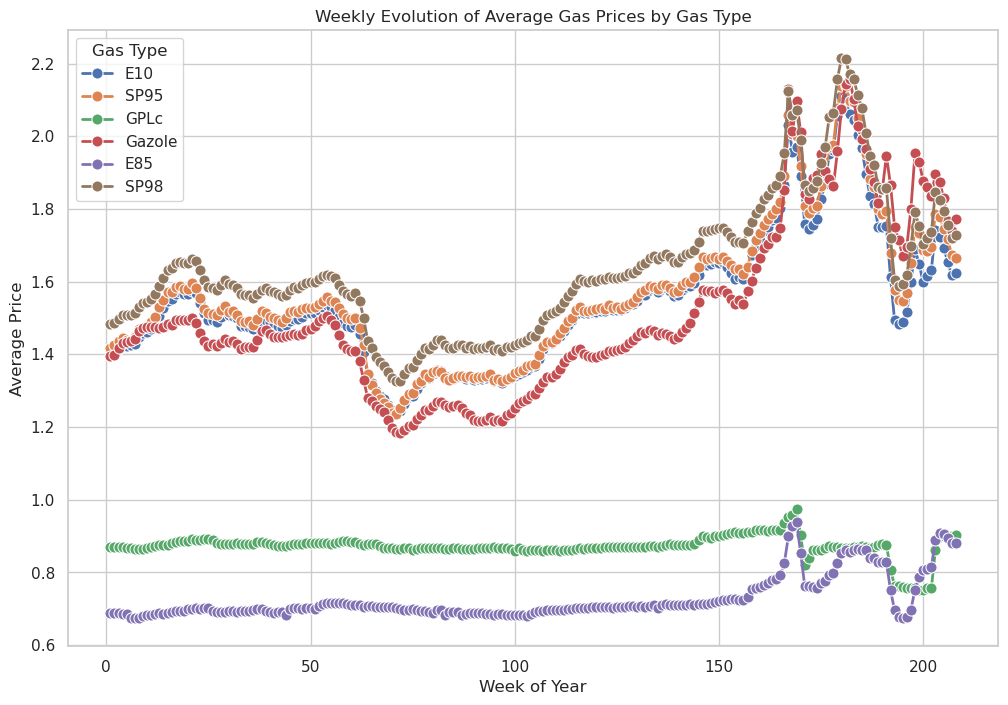

In [47]:
# Convert PySpark DataFrame to Pandas DataFrame for plotting
pandas_df = average_price_gas_type.toPandas()

# Initialize Seaborn
sns.set(style="whitegrid")

# Create a line plot for each gas type
plt.figure(figsize=(12, 8))
sns.lineplot(data=pandas_df, x="continuous_week_number", y="avg_price", hue="nom_carburant", marker="o", markersize=8, linewidth=2)
plt.title("Weekly Evolution of Average Gas Prices by Gas Type")
plt.xlabel("Week of Year")
plt.ylabel("Average Price")
plt.legend(title="Gas Type")

# Show the plot
plt.show()

### Data Visualization Bonus
* Represent a map for each gas type of France geo heat maps of price indexes, for example at department level

## Modeling - Forecast next day price
* Build a model based on Spark ML to forecast the next day price for gas type in a station
(Do not consider using time series models but rely on existing techniques from Spark ML / MLLib such as LInearRegression, RandomForestRegressor
* Provide relevant accuracy measures and a relevant dispersion plot between actual and forecast


### Variables to be used in regression
* prix (number; gas price)
* latitude_adj and longitude_adj (number; station information)
* id_carburant (number; gas type)


In [48]:
prices_df.printSchema()

root
 |-- id_pdv: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- id_carburant: string (nullable = true)
 |-- nom_carburant: string (nullable = true)
 |-- prix: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- WeekOfYear: integer (nullable = true)
 |-- continuous_week_number: integer (nullable = true)
 |-- latitude_int: integer (nullable = true)
 |-- longitude_int: integer (nullable = true)
 |-- latitude_adj: double (nullable = true)
 |-- longitude_adj: double (nullable = true)
 |-- prix_int: double (nullable = true)
 |-- prix_adj: double (nullable = true)



In [49]:
from pyspark.sql import Window
from pyspark.sql.functions import lag


# Assume df is your DataFrame and it has columns 'latitude', 'longitude', 'population', 'price' and 'time'
window = Window.partitionBy('id_pdv', 'nom_carburant').orderBy('Date')
prices_df = prices_df.withColumn('lagged_price', lag('prix_adj').over(window))

prices_df.show(5)

+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+--------+------------+
| id_pdv|   cp|pop|latitude|longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|latitude_adj|longitude_adj|prix_int|prix_adj|lagged_price|
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+--------+------------+
|1000004|01000|  R| 4618800|   524500|2022-11-18|           3|          E85|1.76|2022|   11| 18|        46|                   203|     4618800|       524500|     0.46188|       0.5245|    1.76|    1.76|        NULL|
|1000007|01000|  R| 4620105|   524891|2019-01-03|           5|          E10|1320|2019|    1|  3|         1|                     1|     4

In [56]:
# Remove rows with any null value in the specified columns
columns_to_check = ["pop", "nom_carburant", "latitude_adj", "longitude_adj", "WeekOfYear", "lagged_price"]
prices_df_cleaned = prices_df.dropna(subset=columns_to_check)

In [40]:
test = prices_df[prices_df["Year"] == "2019"]

In [57]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Define stages for the feature transformation pipeline
pop_indexer = StringIndexer(inputCol="pop", outputCol="pop_string")
ohe_pop = OneHotEncoder(inputCol="pop_string", outputCol="ohe_pop")
gas_indexer = StringIndexer(inputCol="nom_carburant", outputCol="carburant_string")
ohe_gas = OneHotEncoder(inputCol="carburant_string", outputCol="ohe_carburant")
assembler = VectorAssembler(inputCols=["ohe_pop", "ohe_carburant", "latitude_adj", "longitude_adj", "WeekOfYear", "lagged_price"],
                            outputCol="features")

# Combine these stages into a preprocessing pipeline
preprocessing_pipeline = Pipeline(stages=[pop_indexer, ohe_pop, gas_indexer, ohe_gas, assembler])
preprocessed_data = preprocessing_pipeline.fit(prices_df_cleaned).transform(prices_df_cleaned)
preprocessed_data.show(5)

+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+--------+------------+----------+-------------+----------------+-------------+--------------------+
| id_pdv|   cp|pop|latitude|longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|latitude_adj|longitude_adj|prix_int|prix_adj|lagged_price|pop_string|      ohe_pop|carburant_string|ohe_carburant|            features|
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+--------+------------+----------+-------------+----------------+-------------+--------------------+
|1000007|01000|  R| 4620105|   524891|2019-01-08|           5|          E10|1357|2019|    1|  8|         2|              

In [58]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol='prix_adj')
rf_model = rf.fit(preprocessed_data)
rf_predictions = rf_model.transform(preprocessed_data)
rf_predictions.show(5)

24/01/19 22:16:55 WARN MemoryStore: Not enough space to cache rdd_995_11 in memory! (computed 40.8 MiB so far)
24/01/19 22:16:55 WARN MemoryStore: Not enough space to cache rdd_995_6 in memory! (computed 40.8 MiB so far)
24/01/19 22:16:55 WARN MemoryStore: Not enough space to cache rdd_995_13 in memory! (computed 40.8 MiB so far)
24/01/19 22:16:55 WARN BlockManager: Persisting block rdd_995_11 to disk instead.
24/01/19 22:16:55 WARN BlockManager: Persisting block rdd_995_13 to disk instead.
24/01/19 22:16:55 WARN BlockManager: Persisting block rdd_995_6 to disk instead.
24/01/19 22:16:55 WARN MemoryStore: Not enough space to cache rdd_995_14 in memory! (computed 40.8 MiB so far)
24/01/19 22:16:55 WARN BlockManager: Persisting block rdd_995_14 to disk instead.
24/01/19 22:16:55 WARN MemoryStore: Not enough space to cache rdd_995_9 in memory! (computed 40.8 MiB so far)
24/01/19 22:16:55 WARN BlockManager: Persisting block rdd_995_9 to disk instead.
24/01/19 22:16:55 WARN MemoryStore: Not

+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+--------+------------+----------+-------------+----------------+-------------+--------------------+------------------+
| id_pdv|   cp|pop|latitude|longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|latitude_adj|longitude_adj|prix_int|prix_adj|lagged_price|pop_string|      ohe_pop|carburant_string|ohe_carburant|            features|        prediction|
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+--------+------------+----------+-------------+----------------+-------------+--------------------+------------------+
|1000007|01000|  R| 4620105|   524891|2019-01-08|           5|  

In [60]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol="features", labelCol='prix_adj')
lr_model = lr.fit(preprocessed_data)
lr_predictions = lr_model.transform(preprocessed_data)
lr_predictions.show(5)

24/01/19 22:23:01 WARN Instrumentation: [7f229fac] regParam is zero, which might cause numerical instability and overfitting.
24/01/19 22:23:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/01/19 22:23:53 WARN Instrumentation: [99e0b9dc] regParam is zero, which might cause numerical instability and overfitting.


+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+--------+------------+----------+-------------+----------------+-------------+--------------------+------------------+
| id_pdv|   cp|pop|latitude|longitude|      Date|id_carburant|nom_carburant|prix|Year|Month|Day|WeekOfYear|continuous_week_number|latitude_int|longitude_int|latitude_adj|longitude_adj|prix_int|prix_adj|lagged_price|pop_string|      ohe_pop|carburant_string|ohe_carburant|            features|        prediction|
+-------+-----+---+--------+---------+----------+------------+-------------+----+----+-----+---+----------+----------------------+------------+-------------+------------+-------------+--------+--------+------------+----------+-------------+----------------+-------------+--------------------+------------------+
|1000007|01000|  R| 4620105|   524891|2019-01-08|           5|  